In [47]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

#!pip install prophet --quiet
from prophet import Prophet

In [49]:
# Load the dataset
df = pd.read_csv('3. Data/household_power_consumption.txt', sep=';', low_memory = False)

In [50]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [51]:
# View basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [52]:
# Combine 'date' and 'time' into one datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Set datetime as index
df.set_index('datetime', inplace=True)

# Drop original 'date' and 'time'
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Convert target column to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Now resample correctly (use lowercase 'h' instead of deprecated 'H')
df_power_hourly = df[['Global_active_power']].resample('h').mean()

# Fill missing values
df_power_hourly.ffill()

# Confirm
df_power_hourly.head()

,Global_active_power
datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


In [53]:
df_power_hourly['hour'] = df_power_hourly.index.hour
df_power_hourly['dayofweek'] = df_power_hourly.index.dayofweek
df_power_hourly['is_weekend'] = (df_power_hourly['dayofweek'] >= 5).astype(int)

In [54]:
df_power_hourly

,Global_active_power,hour,dayofweek,is_weekend
datetime,,,,
2006-12-16 17:00:00,4.222889,17,5,1
2006-12-16 18:00:00,3.632200,18,5,1
2006-12-16 19:00:00,3.400233,19,5,1
2006-12-16 20:00:00,3.268567,20,5,1
2006-12-16 21:00:00,3.056467,21,5,1
...,...,...,...,...
2010-11-26 17:00:00,1.725900,17,4,0
2010-11-26 18:00:00,1.573467,18,4,0
2010-11-26 19:00:00,1.659333,19,4,0


In [55]:
# Train-test split
train = df_power_hourly['Global_active_power'][:-168]  # last 7 days for test
test = df_power_hourly['Global_active_power'][-168:]

# Fit ARIMA
model_arima = ARIMA(train, order=(2,1,2))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=168)

# Evaluation
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
print(f"ARIMA - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA - MAE: 0.70, RMSE: 0.86


In [56]:
df_prophet = df_power_hourly.reset_index()[['datetime', 'Global_active_power']].rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})
train_prophet = df_prophet[:-168]
test_prophet = df_prophet[-168:]

model_prophet = Prophet()
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=168, freq='H')
forecast_prophet = model_prophet.predict(future)

# Evaluation
y_true = test_prophet['y'].values
y_pred = forecast_prophet['yhat'][-168:].values
mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Prophet - MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")


12:35:18 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet - MAE: 0.61, RMSE: 0.76


In [72]:
!pip install xgboost --quiet
import xgboost as xgb

# Prepare features
df_ml = df_power_hourly.dropna().copy()
features = ['hour', 'dayofweek', 'is_weekend']
target = 'Global_active_power'

X = df_ml[features]
y = df_ml[target]

# Train-test split
X_train, X_test = X[:-168], X[-168:]
y_train, y_test = y[:-168], y[-168:]

# Fit model
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")


XGBoost - MAE: 0.48, RMSE: 0.69


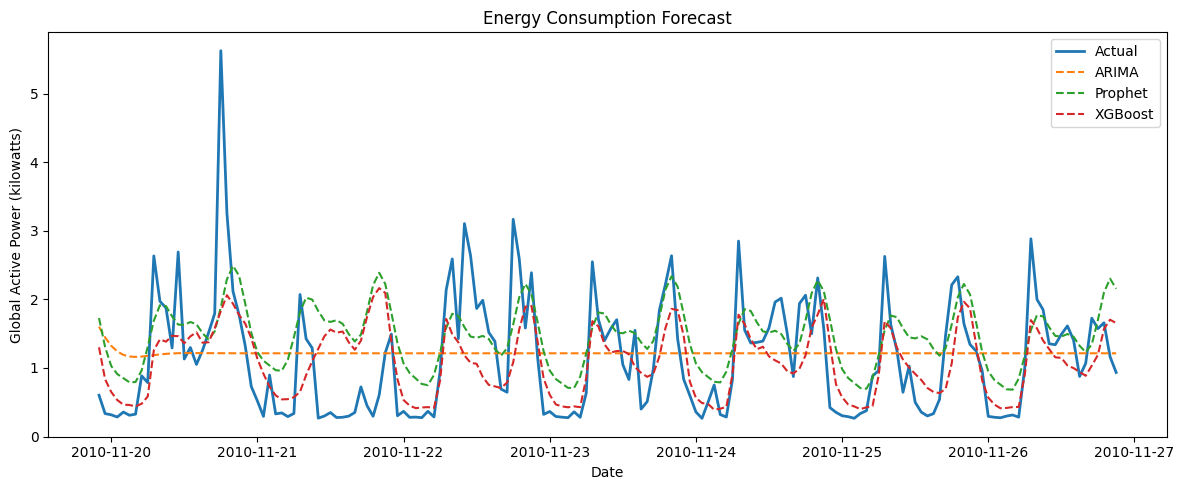

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label='Actual', linewidth=2)
plt.plot(test.index, forecast_arima, label='ARIMA', linestyle='--')
plt.plot(test.index, y_pred, label='Prophet', linestyle='--')
plt.plot(test.index, y_pred_xgb, label='XGBoost', linestyle='--')
plt.title('Energy Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.tight_layout()
plt.show()